In [1]:
import os
import ast
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import config

# Note:     (kl loss) 0 <= alpha <= 1 (next_token loss)

In [2]:
load_all = False
exclude = ["seed_20", "seed_32", "seed_36", "seed_40"]

csv_log_dir = "/home/klambert/projects/aip-craffel/klambert/SLMensembles/csv_logs"
subdirs = ["22-07-2025", "29-07-2025", "30-07-2025"]
filenames = ["alpha08_hyperparameters_metrics", "alpha07_hyperparameters_metrics", "ensemble_alpha_08_metrics", "ensemble_alpha_07_metrics"]
all_dfs = []

for i in range(len(subdirs)):
    csv_full_dir = os.path.join(csv_log_dir, subdirs[i])
    csv_files = glob.glob(os.path.join(csv_full_dir, "*.csv")) # finds all files with extension .csv in csv_full_dir

    dfs = {}
    for filepath in csv_files:        
        name = os.path.splitext(os.path.basename(filepath))[0]
        if name in exclude:
            continue
        if not load_all and name not in filenames:
            continue
        
        df = pd.read_csv(filepath, low_memory=False)
        df["source"] = name
        all_dfs.append(df)

combined_df = pd.concat(all_dfs, ignore_index=True)

print(combined_df["source"].value_counts())


source
alpha07_hyperparameters_metrics    304231
alpha08_hyperparameters_metrics    304157
ensemble_alpha_07_metrics          103300
ensemble_alpha_08_metrics           54760
Name: count, dtype: int64


/tmp/ipykernel_3990932/3841400400.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_dfs, ignore_index=True)


In [3]:
sources = combined_df["source"].unique()

cmap = plt.get_cmap('inferno')

color_map = {source: cmap(0.8 * i / max(1, len(sources) - 1)) for i, source in enumerate(sources)}

color_map["default"] = "black"

print("Generated color map:")
for source, color in color_map.items():
    if source != "default":
        print(f'    "{source}": "{color}",')

Generated color map:
    "alpha07_hyperparameters_metrics": "(np.float64(0.001462), np.float64(0.000466), np.float64(0.013866), np.float64(1.0))",
    "alpha08_hyperparameters_metrics": "(np.float64(0.366529), np.float64(0.071579), np.float64(0.431994), np.float64(1.0))",
    "ensemble_alpha_07_metrics": "(np.float64(0.780517), np.float64(0.243327), np.float64(0.299523), np.float64(1.0))",
    "ensemble_alpha_08_metrics": "(np.float64(0.987622), np.float64(0.64532), np.float64(0.039886), np.float64(1.0))",


In [4]:
for df in all_dfs:
    metadata_str = df[df["metadata"].notna()]["metadata"].iloc[0]
    metadata = ast.literal_eval(metadata_str)

    print(f"\n==== METADATA FROM {metadata.get('Custom run name','N/A')} ====")
    print(f"Run ID String: {metadata.get('ID string', 'N/A')}")
    print(f"Run Description: {metadata.get('Description', 'N/A')}\n")

    for key, value in metadata.items():
        print(f"{key}: {value}")


==== METADATA FROM alpha07_hyperparameters ====
Run ID String: Experiment with hyperparameters to check if distillation works
Run Description: Alpha tweaking: alpha = 0.7

Custom run name: alpha07_hyperparameters
Description: Alpha tweaking: alpha = 0.7
Teacher Model: Qwen/Qwen2.5-7B-Instruct
Student Model: Qwen/Qwen2.5-0.5B-Instruct
Dataset Name: allenai/tulu-3-sft-mixture
Dataset Type: full
Alpha: 0.7
Learning rate: 5e-05
Total Rounds: 1
Steps per Round: -1
Eval batch size: 4
Start Time: 2025-07-22 11:44:26
Model Save Dir: /scratch/klambert/model_log/22-07-2025/run_3_alpha07_hyperparameters
ID string: Experiment with hyperparameters to check if distillation works

==== METADATA FROM alpha08_hyperparameters ====
Run ID String: Experiment with hyperparameters to check if distillation works
Run Description: Alpha tweaking: alpha = 0.8

Custom run name: alpha08_hyperparameters
Description: Alpha tweaking: alpha = 0.8
Teacher Model: Qwen/Qwen2.5-7B-Instruct
Student Model: Qwen/Qwen2.5-0.

IndexError: single positional indexer is out-of-bounds

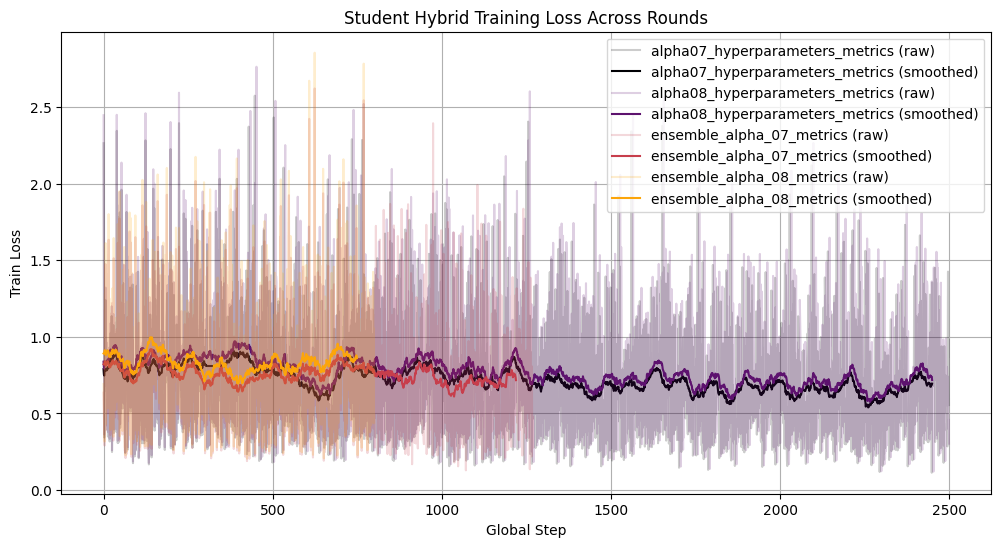

In [ ]:
# Student train loss (hybrid) over rounds
side_by_side = False
x_min_loss = False
min_len = 2500

filter_size = 51
kernel = np.ones(filter_size) / filter_size


if not side_by_side:
    # Display values on the x-axis only up to the minimum number of logged lines across files
    if x_min_loss:
        for name, df in combined_df.groupby("source"):
            student_train_df = df[(df["role"] == "student") & (df["phase"] == "train") & (df["function"] == "compute_loss")]

            loss = student_train_df["train_loss"].to_numpy()
            min_len = min(min_len, len(loss))

    plt.figure(figsize=(12, 6))

    for name, df in combined_df.groupby("source"):

        student_train_df = df[(df["role"] == "student") & (df["phase"] == "train") & (df["function"] == "compute_loss")]

        loss = student_train_df["train_loss"].to_numpy()[:min_len]
        smoothed = scipy.signal.fftconvolve(loss, kernel, mode="valid")

        color = color_map.get(name, color_map["default"])
        plt.plot(range(len(loss)), loss, alpha=0.2, label=f"{name} (raw)", color=color)
        plt.plot(range(len(smoothed)), smoothed, label=f"{name} (smoothed)", color=color)

    plt.title("Student Hybrid Training Loss Across Rounds")
    plt.xlabel("Global Step")
    plt.ylabel("Train Loss")
    plt.legend()
    plt.grid(True)
    # plt.yscale("log")
    plt.show()
else:
    num_files = len(dfs)
    cols = min(num_files, 3)
    rows = (num_files + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows), squeeze=False)

    for idx, (name, df) in enumerate(dfs.items()):
        row, col = divmod(idx, cols)
        ax = axes[row][col]

        student_train_df = df[(df["role"] == "student") & (df["phase"] == "train") & (df["function"] == "compute_loss")]

        loss = student_train_df["train_loss"].to_numpy()
        if len(loss) < filter_size:
            ax.set_title(f"{name} (too short)")
            ax.axis("off")
            continue

        smoothed = scipy.signal.fftconvolve(loss, kernel, mode="valid")

        color = color_map.get(name, color_map["default"])
        ax.plot(range(len(loss)), loss, alpha=0.3, label=f"Raw", color=color)
        ax.plot(range(len(smoothed)), smoothed, label=f"Smoothed", color=color)
        
        ax.set_title(f"Training Loss: {name}")
        ax.set_xlabel("Global Step")
        ax.set_ylabel("Train Loss")
        ax.legend()

    # Hide any unused subplots
    for i in range(idx + 1, rows * cols):
        row, col = divmod(i, cols)
        axes[row][col].axis("off")

    plt.yscale("log")
    plt.tight_layout()
    plt.show()

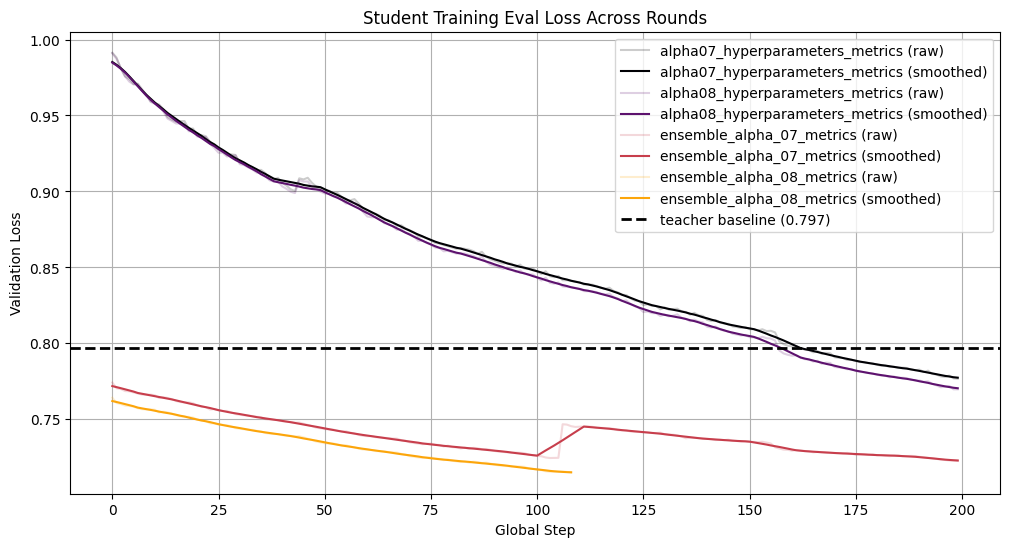

In [5]:
# Student Training Eval Loss Across Rounds

side_by_side = False
x_min_loss = False  # Display values on the x-axis only up to the minimum number of logged lines across files
min_len = 200

filter_size = 11
kernel = np.ones(filter_size) / filter_size

if not side_by_side:
    if x_min_loss:
        for name, df in combined_df.groupby("source"):
            student_train_df = df[(df["role"] == "student") & (df["phase"] == "eval") & (df["function"] == "evaluation_loop")]

            loss = student_train_df["eval_loss"].to_numpy()
            min_len = min(min_len, len(loss))

    plt.figure(figsize=(12, 6))

    for name, df in combined_df.groupby("source"):
        student_train_df = df[(df["role"] == "student") & (df["phase"] == "eval") & (df["function"] == "evaluation_loop")]

        loss = student_train_df["eval_loss"].to_numpy()[:min_len]
        pad = (filter_size - 1) // 2
        padded_loss = np.pad(loss, pad_width=pad, mode="edge")
        smoothed = scipy.signal.fftconvolve(padded_loss, kernel, mode="valid")

        color = color_map.get(name, color_map["default"])
        plt.plot(range(len(loss)), loss, alpha=0.2, label=f"{name} (raw)", color=color)
        plt.plot(range(len(smoothed)), smoothed, label=f"{name} (smoothed)", color=color)

    baseline_teacher_loss = 0.7968094515065487
    plt.axhline(baseline_teacher_loss, color="black", linestyle="--", linewidth=2,
                label=f"teacher baseline ({baseline_teacher_loss:.3f})")

    plt.title("Student Training Eval Loss Across Rounds")
    plt.xlabel("Global Step")
    plt.ylabel("Validation Loss")
    plt.legend()
    plt.grid(True)
    # plt.yscale("log")
    plt.show()
else:
    num_files = len(dfs)
    cols = min(num_files, 3)
    rows = (num_files + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows), squeeze=False)

    for idx, (name, df) in enumerate(dfs.items()):
        row, col = divmod(idx, cols)
        ax = axes[row][col]

        student_train_df = df[(df["role"] == "student") & (df["phase"] == "eval") & (df["function"] == "evaluation_loop")]

        loss = student_train_df["eval_loss"].to_numpy()
        if len(loss) < filter_size:
            ax.set_title(f"{name} (too short)")
            ax.axis("off")
            continue

        smoothed = scipy.signal.fftconvolve(loss, kernel, mode="valid")

        color = color_map.get(name, color_map["default"])
        ax.plot(range(len(loss)), loss, alpha=0.3, label=f"Raw", color=color)
        ax.plot(range(len(smoothed)), smoothed, label=f"Smoothed", color=color)
        
        ax.set_title(f"Validation Loss: {name}")
        ax.set_xlabel("Global Step")
        ax.set_ylabel("Validation Loss")
        ax.legend()

    # Hide any unused subplots
    for i in range(idx + 1, rows * cols):
        row, col = divmod(i, cols)
        axes[row][col].axis("off")

    plt.yscale("log")
    plt.tight_layout()
    plt.show()

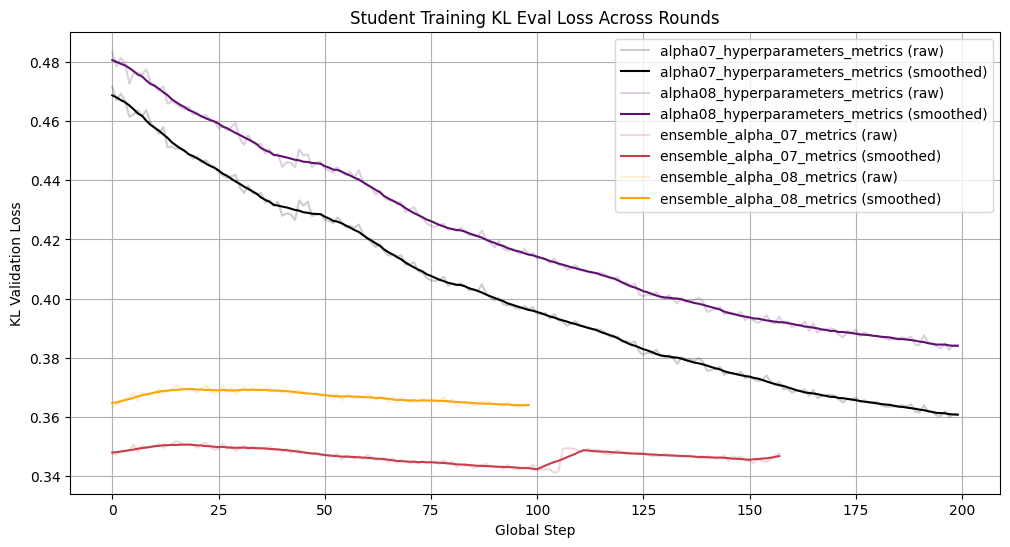

In [ ]:
# Student train loss (kl) over rounds
side_by_side = False
x_min_loss = False
min_len = 200

filter_size = 11
kernel = np.ones(filter_size) / filter_size

if not side_by_side:
    # Display values on the x-axis only up to the minimum number of logged lines across files
    if x_min_loss:
        for name, df in combined_df.groupby("source"):
            student_train_df = df[
                (df["role"] == "student") &
                (df["phase"] == "eval") &
                (df["function"] == "evaluation_loop")
            ]

            loss = student_train_df["eval_loss"].to_numpy()
            min_len = min(min_len, len(loss))

    plt.figure(figsize=(12, 6))

    for  name, df in combined_df.groupby("source"):
        student_train_df = df[
            (df["role"] == "student") &
            (df["phase"] == "eval") &
            (df["function"] == "evaluation_loop")
        ]

        loss = student_train_df["eval_kl_loss"].to_numpy()[:min_len]
        pad = (filter_size - 1) // 2
        padded_loss = np.pad(loss, pad_width=pad, mode='edge')
        smoothed = scipy.signal.fftconvolve(padded_loss, kernel, mode="valid")

        color = color_map.get(name, color_map["default"])
        plt.plot(range(len(loss)), loss, alpha=0.2, label=f"{name} (raw)", color=color)
        plt.plot(range(len(smoothed)), smoothed, label=f"{name} (smoothed)", color=color)


    plt.title("Student Training KL Eval Loss Across Rounds")
    plt.xlabel("Global Step")
    plt.ylabel("KL Validation Loss")
    plt.legend()
    plt.grid(True)
    # plt.yscale("log")
    plt.show()
else:
    num_files = len(dfs)
    cols = min(num_files, 3)
    rows = (num_files + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows), squeeze=False)
    
    for idx, (name, df) in enumerate(dfs.items()):
        row, col = divmod(idx, cols)
        ax = axes[row][col]

        student_train_df = df[
            (df["role"] == "student") &
            (df["phase"] == "eval") &
            (df["function"] == "evaluation_loop")
        ]

        loss = student_train_df["eval_kl_loss"].to_numpy()
        if len(loss) < filter_size:
            ax.set_title(f"{name} (too short)")
            ax.axis("off")
            continue

        smoothed = scipy.signal.fftconvolve(loss, kernel, mode="valid")

        color = color_map.get(name, color_map["default"])
        ax.plot(range(len(loss)), loss, alpha=0.3, label=f"Raw", color=color)
        ax.plot(range(len(smoothed)), smoothed, label=f"Smoothed", color=color)
        
        ax.set_title(f"KL Validation Loss: {name}")
        ax.set_xlabel("Global Step")
        ax.set_ylabel("KL Loss")
        ax.legend()

    # Hide any unused subplots
    for i in range(idx + 1, rows * cols):
        row, col = divmod(i, cols)
        axes[row][col].axis("off")
    
    plt.yscale("log")
    plt.tight_layout()
    plt.show()

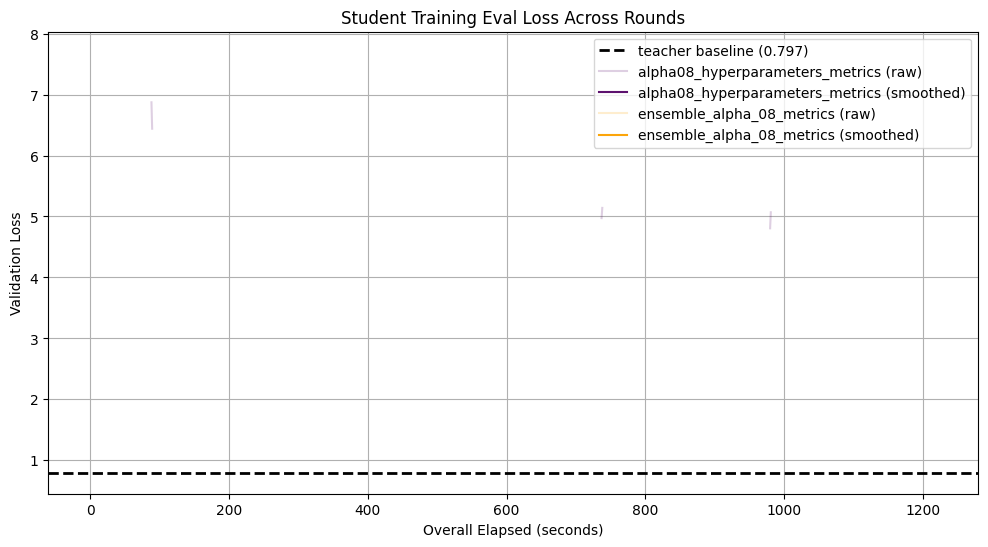

In [ ]:
# Student Training Eval Loss Across Rounds

wanted = ["alpha08_hyperparameters_metrics", "ensemble_alpha_08_metrics"] 

filter_size = 3
kernel = np.ones(filter_size) / filter_size

subset_df = combined_df[combined_df["source"].isin(wanted)]

plt.figure(figsize=(12, 6))

for name, df in subset_df.groupby("source"):
    student_eval_df = df[(df["role"] == "student") & (df["phase"] == "train") & (df["function"] == "on_log")]
    
    loss = student_eval_df["train_loss"].to_numpy()
    
    pad = (filter_size - 1) // 2
    padded_loss = np.pad(loss, pad_width=pad, mode="edge")
    smoothed = scipy.signal.fftconvolve(padded_loss, kernel, mode="valid")

    color = color_map.get(name, color_map["default"])
    plt.plot(range(len(loss)), loss, alpha=0.2, label=f"{name} (raw)", color=color)
    plt.plot(range(len(smoothed)), smoothed, label=f"{name} (smoothed)", color=color)

plt.title("Student Training Eval Loss Across Rounds")
plt.xlabel("Overall Elapsed (seconds)")
plt.ylabel("Validation Loss")
plt.legend()
plt.grid(True)
# plt.yscale("log")
plt.show()